In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2020],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35279 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 213 ms, sys: 34.5 ms, total: 247 ms
Wall time: 240 ms


# config_year.year 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2020,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [7]:
first_size = get_ddf_shape(data[config_year.year])

# Visualization 2020

In [8]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 11.6 ms


In [9]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed 00 rows
dropped 04 columns
CPU times: user 163 ms, sys: 50.9 ms, total: 214 ms
Wall time: 1.57 s


In [10]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [11]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 673 ms, sys: 212 ms, total: 884 ms
Wall time: 6.53 s


In [12]:
nans

{'ctx0': 0.0003354445842751406,
 'ctx1': 0.0003354445842751406,
 'ctx2': 0.0003354445842751406,
 'ctx3': 0.0003354445842751406,
 'ctx4': 0.0003354445842751406}

In [13]:
zeros

{'num_bikes_available': 3.7177602812367394,
 'num_bikes_available_types.mechanical': 10.9436000248229,
 'num_bikes_available_types.ebike': 34.74171605622275,
 'num_docks_available': 0.9711959326226007,
 'is_installed': 0.015821802891644133,
 'is_renting': 0.6036045756877593,
 'is_returning': 0.5915006169384979,
 'is_charging_station': 0.0010622411835379453,
 'status': 99.41020455969823,
 'dayofweek': 14.429987404055861,
 'hour': 4.134494269767889,
 'capacity': 0.0003354445842751406,
 'ctx0': 0.9708604880383257,
 'ctx1': 0.970357321161913,
 'ctx2': 0.9716711457836572,
 'ctx3': 0.9732365538436079,
 'ctx4': 0.9741031190196521}

In [14]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [15]:
uniques

{'station_id': 0        1
 1      301
 2      300
 3      299
 4       14
       ... 
 513    530
 514    526
 515    521
 516    525
 517    524
 Name: station_id, Length: 518, dtype: int64,
 'num_bikes_available': 0       28.625000
 1       34.666667
 2       24.000000
 3       24.100000
 4       15.375000
           ...    
 4572    12.416667
 4573    28.333333
 4574    22.227273
 4575     1.885714
 4576    13.888889
 Name: num_bikes_available, Length: 4577, dtype: float64,
 'num_bikes_available_types.mechanical': 0       28.625000
 1       34.666667
 2       23.000000
 3       15.000000
 4       27.875000
           ...    
 3904    13.114286
 3905    48.916667
 3906    12.277778
 3907     1.526316
 3908    52.083333
 Name: num_bikes_available_types.mechanical, Length: 3909, dtype: float64,
 'num_bikes_available_types.ebike': 0        0.000000
 1        1.000000
 2        1.100000
 3        0.375000
 4        0.625000
           ...    
 1738    19.083333
 1739     3.894737
 1740  

## 2020 station_id

In [16]:
%%time

print(stats.describe(data[config_year.year].station_id))
data[config_year.year].station_id.describe().compute()

DescribeResult(nobs=3577342, minmax=(1, 530), mean=248.99138913752165, variance=20663.436331831665, skewness=0.055195478208244046, kurtosis=-1.1109810905661623)
CPU times: user 638 ms, sys: 130 ms, total: 768 ms
Wall time: 3.42 s


count    3.577342e+06
mean     2.489914e+02
std      1.437478e+02
min      1.000000e+00
25%      1.270000e+02
50%      2.490000e+02
75%      3.690000e+02
max      5.300000e+02
Name: station_id, dtype: float64

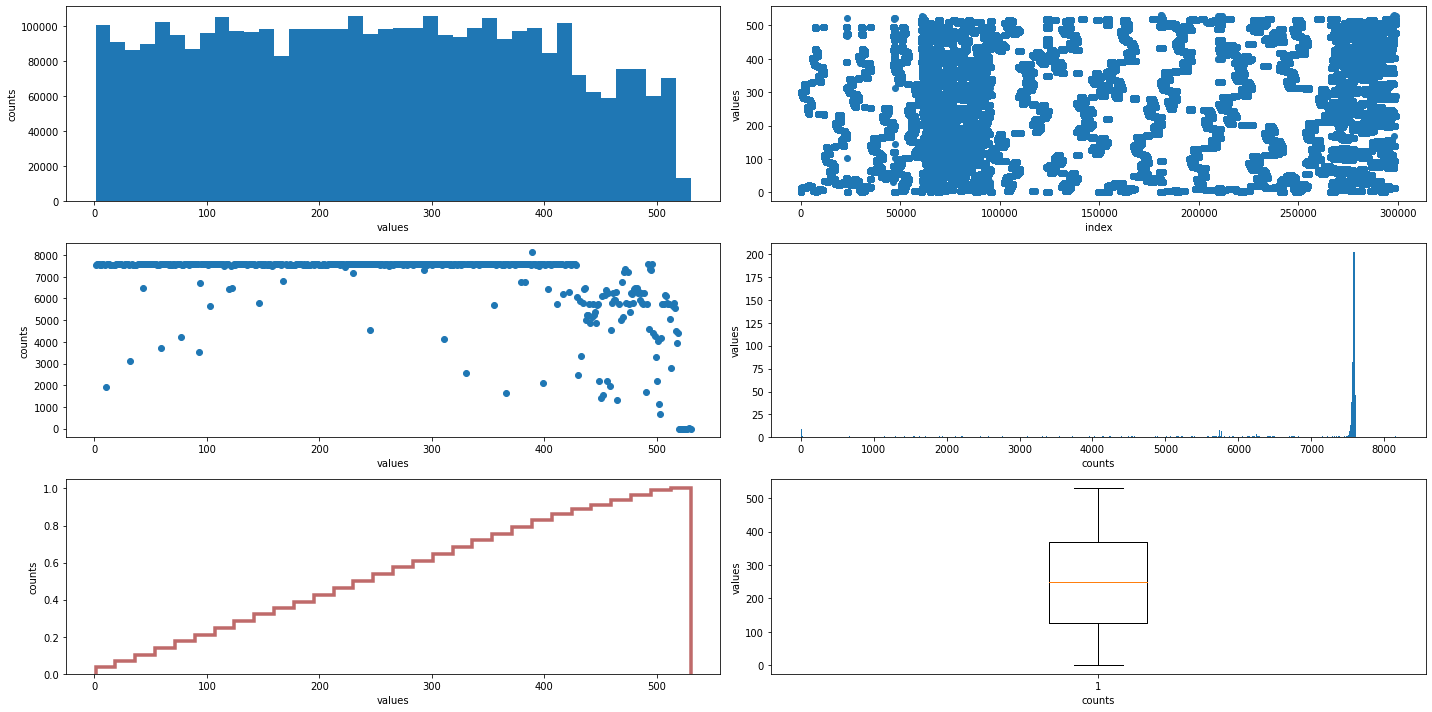

CPU times: user 7.03 s, sys: 1.16 s, total: 8.18 s
Wall time: 8.1 s


In [17]:
%%time

show_counts(data[config_year.year].station_id.compute())

value counts stats {'max': 8160, 'mean': 6906.065637065637, 'median': 7575.0, 'std': 1583.5845535482574, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.77 s, sys: 0 ns, total: 1.77 s
Wall time: 9.78 s


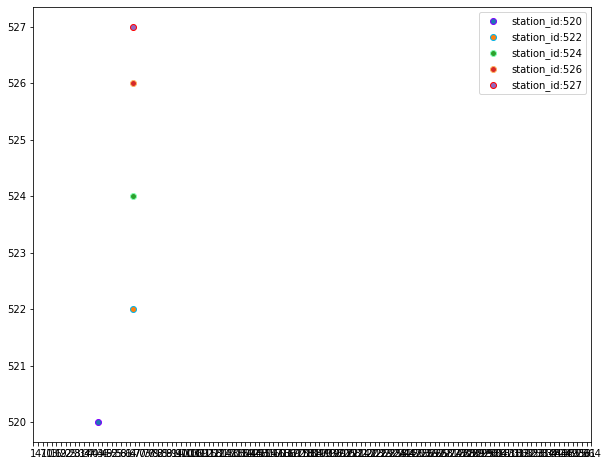

In [18]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofyear', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=np.arange(uniques['dayofyear'].min(),uniques['dayofyear'].max(), 3.0),
    figsize=(10,8)
)

## 2020 num_bikes_available

In [19]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=3577342, minmax=(0.0, 198.0), mean=9.930076086735802, variance=65.00647958160091, skewness=0.9240636670036411, kurtosis=2.6802257259500024)
CPU times: user 722 ms, sys: 143 ms, total: 865 ms
Wall time: 3.65 s


count    3.577342e+06
mean     9.930076e+00
std      8.062660e+00
min      0.000000e+00
25%      2.900000e+00
50%      8.750000e+00
75%      1.528571e+01
max      1.980000e+02
Name: num_bikes_available, dtype: float64

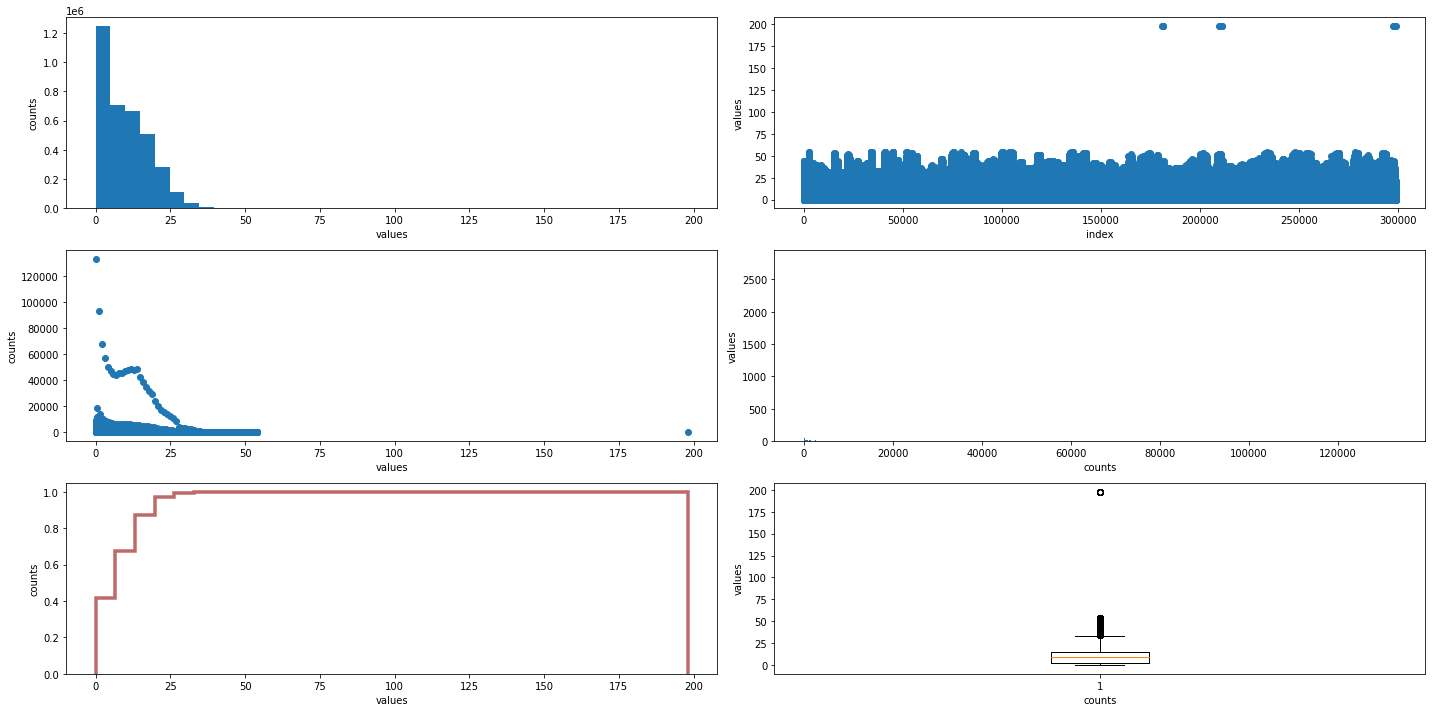

CPU times: user 12.5 s, sys: 1.54 s, total: 14 s
Wall time: 15.1 s


In [20]:
%%time

show_counts(data[config_year.year].num_bikes_available.compute())

327
value counts stats {'max': 8160, 'mean': 6906.065637065637, 'median': 7575.0, 'std': 1583.5845535482574, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.92 s, sys: 184 ms, total: 2.1 s
Wall time: 10.8 s


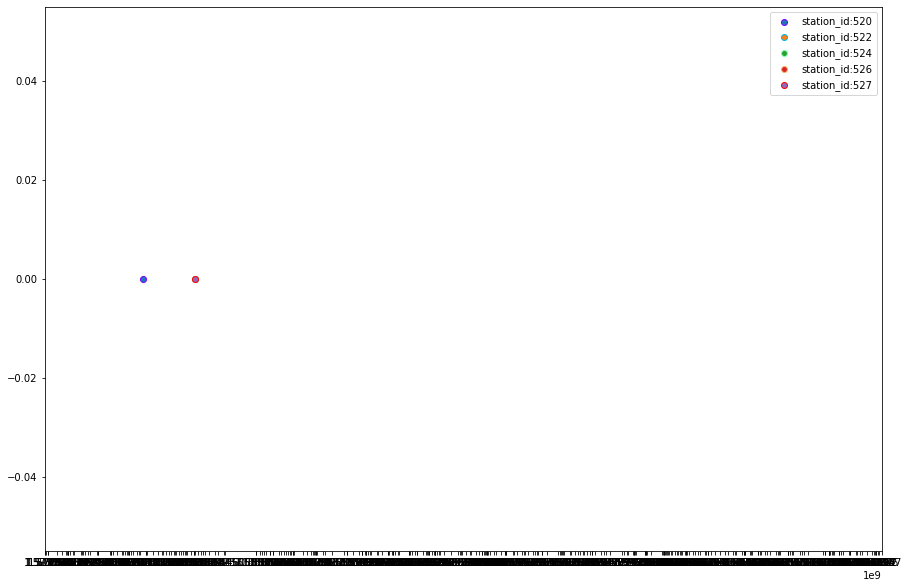

In [21]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 8160, 'mean': 6906.065637065637, 'median': 7575.0, 'std': 1583.5845535482574, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.37 s, sys: 149 ms, total: 1.52 s
Wall time: 9.2 s


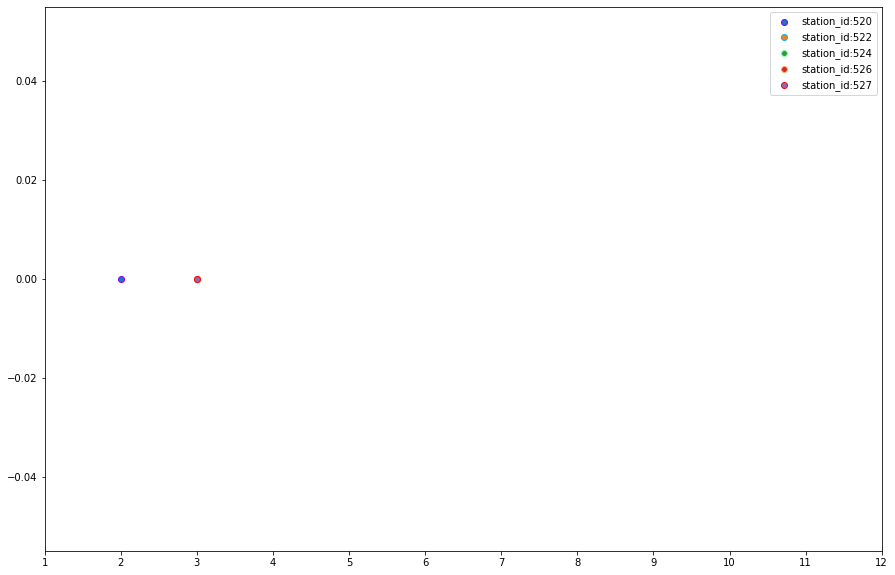

In [22]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8160, 'mean': 6906.065637065637, 'median': 7575.0, 'std': 1583.5845535482574, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.24 s, sys: 85.6 ms, total: 1.32 s
Wall time: 8.47 s


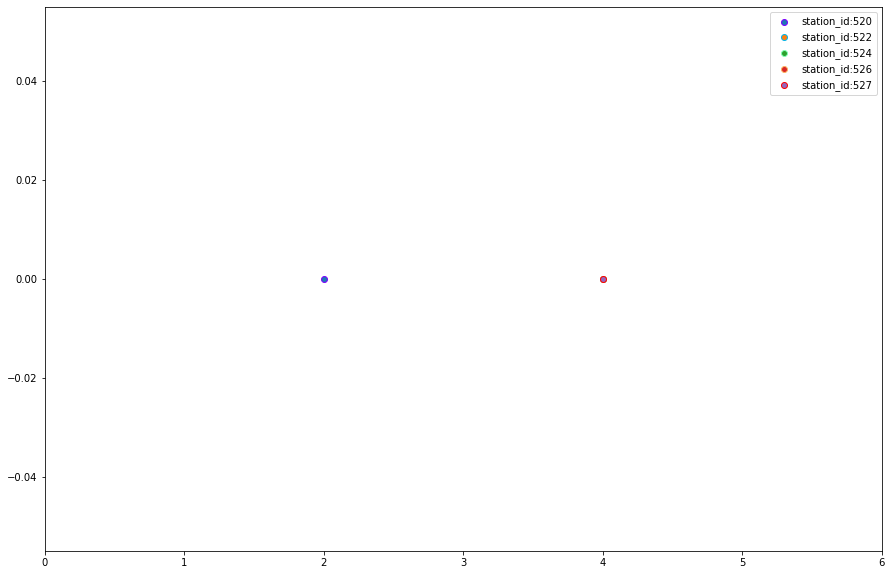

In [23]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8160, 'mean': 6906.065637065637, 'median': 7575.0, 'std': 1583.5845535482574, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.3 s, sys: 110 ms, total: 1.41 s
Wall time: 8.61 s


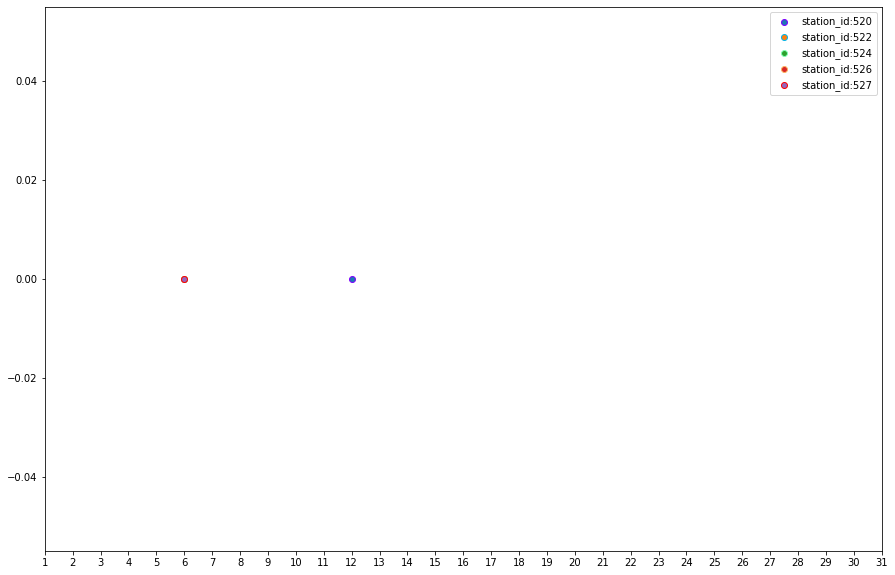

In [24]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 696, 'mean': 696.0, 'median': 696.0, 'std': nan, 'min': 696}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 744, 'mean': 744.0, 'median': 744.0, 'std': nan, 'min': 744}


  0%|          | 0/1 [00:00<?, ?it/s]

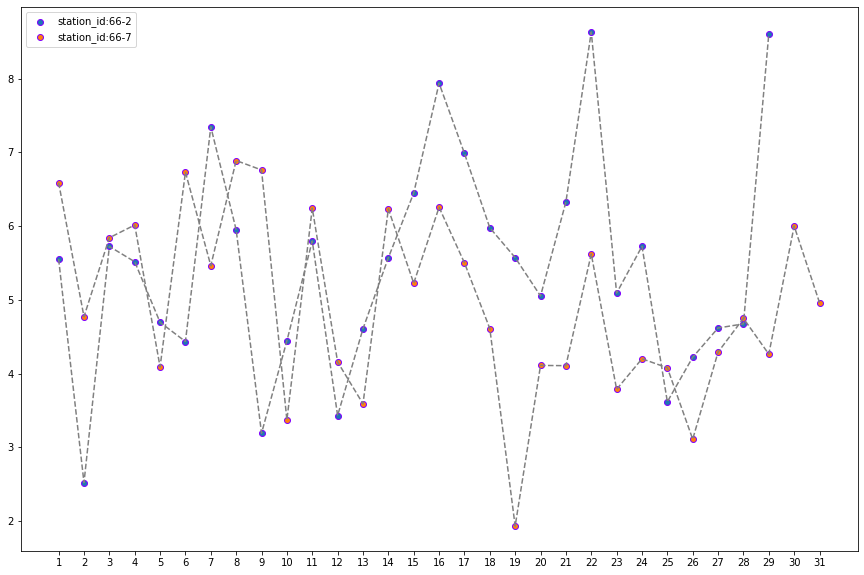

CPU times: user 1.13 s, sys: 104 ms, total: 1.24 s
Wall time: 6.19 s


In [25]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

In [ ]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 696, 'mean': 696.0, 'median': 696.0, 'std': nan, 'min': 696}


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

In [ ]:
%%time

scatter_columns(data[config_year.year], 'hour', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

In [ ]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


In [ ]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


In [ ]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

In [ ]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

## 2020 is_charging_station

In [ ]:
%%time

print(stats.describe(data[config_year.year].is_charging_station))
data[config_year.year].is_charging_station.describe().compute()

In [ ]:
%%time

show_counts(data[config_year.year].is_charging_station.compute())

## 2020 status

In [ ]:
%%time

print(stats.describe(data[config_year.year].status))
data[config_year.year].status.describe().compute()

In [ ]:
%%time

show_counts(data[config_year.year].status.compute())

## 2020 is_installed

In [ ]:
%%time

print(stats.describe(data[config_year.year].is_installed))
data[config_year.year].is_installed.describe().compute()

In [ ]:
%%time

show_counts(data[config_year.year].is_installed.compute())

## 2020 is_renting

In [ ]:
%%time

print(stats.describe(data[config_year.year].is_renting))
data[config_year.year].is_renting.describe().compute()

In [ ]:
%%time

show_counts(data[config_year.year].is_renting.compute())

## 2020 is_returning

In [ ]:
%%time

print(stats.describe(data[config_year.year].is_returning))
data[config_year.year].is_returning.describe().compute()

In [ ]:
%%time

show_counts(data[config_year.year].is_returning.compute())

## 2020 ctx0

In [ ]:
%%time

print(stats.describe(data[config_year.year].ctx0))
data[config_year.year].ctx0.describe().compute()

In [ ]:
%%time

show_counts(data[config_year.year].ctx0.compute())

In [ ]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=1
)


In [ ]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

In [ ]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

In [ ]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


In [ ]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

In [ ]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

In [ ]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

In [ ]:
%%time

scatter_columns(data[config_year.year], 'hour', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

In [ ]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


In [ ]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


In [ ]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

In [ ]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()